In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import sys
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from pathlib import Path
%matplotlib inline
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [3]:
# earliest season data starts in 2002 corresponding to tournament season date of 2003
tournament_season = 2003

In [4]:
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id_no_opp.csv'))

# drop opponent stat columns
summary_data.drop(columns=['allow_fg_pct','allow_ft_att_avg','allow_off_rebs_avg','allow_def_rebs_avg' ], inplace=True)
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]

(5687, 18)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
180,2000,New Orleans,e7ff6d5c-07e9-42af-955d-0a0b8c1e2288,29,-1.95,-3.83,0.586,69,65,0.457,0.680,NaN,NaN,NaN,15,7,NaN,22
398,2001,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,28,-14.55,-7.48,0.321,66,73,0.403,0.656,NaN,NaN,NaN,17,7,NaN,22
489,2001,Morris Brown,NaN,29,-26.38,-1.84,0.172,55,75,0.372,0.582,NaN,NaN,NaN,19,6,NaN,19
718,2002,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,29,-10.58,-10.30,0.586,71,71,0.431,0.677,NaN,NaN,NaN,17,7,NaN,24
811,2002,Morris Brown,NaN,28,-25.25,-10.21,0.286,63,75,0.405,0.629,NaN,NaN,NaN,16,6,NaN,22
983,2003,Birmingham-Southern,NaN,27,-3.27,-9.79,0.741,74,65,0.482,0.695,NaN,NaN,NaN,15,7,NaN,21
1043,2003,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,32,-9.85,-7.94,0.469,72,74,0.415,0.708,NaN,NaN,NaN,16,8,NaN,24
1308,2004,Birmingham-Southern,NaN,30,-7.24,-8.24,0.533,65,63,0.445,0.721,NaN,NaN,NaN,13,5,NaN,22
1368,2004,Florida A&M,cec2527e-5e1e-4817-a628-35666ef13b6e,29,-15.06,-9.24,0.483,68,73,0.425,0.657,NaN,NaN,NaN,17,7,NaN,21
1633,2005,Birmingham-Southern,NaN,28,-5.81,-8.12,0.679,68,64,0.462,0.682,NaN,NaN,NaN,12,6,NaN,21


In [5]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)
summary_data[summary_data.isnull().any(axis=1)]

summary_data.rename(str.lower, axis='columns', inplace=True)
summary_data.head()

(5673, 18)


,season,school,team_id,games,srs,sos,win_pct,pts_avg,opp_pts_avg,fg_pct,ft_pct,poss_avg,off_rebs_avg,def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
0,2000,Air Force,aa7af640-5762-4686-9181-39f7b8a8186e,29,-3.57,1.99,0.276,57,63,0.435,0.697,63.020690,6.0,16.0,13,7,90.446487,16
1,2000,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,28,-3.09,1.67,0.429,67,72,0.452,0.725,73.857143,9.0,20.0,15,5,90.715667,23
2,2000,Alabama,c2104cdc-c83d-40d2-a3cd-df986e29f5d3,36,14.02,6.27,0.694,76,68,0.433,0.698,86.200000,16.0,26.0,15,7,88.167053,24
3,2000,Alabama A&M,949c3398-85e4-4c63-ba71-9a82e06ddea4,28,-13.46,-11.79,0.607,73,74,0.391,0.626,94.264286,17.0,22.0,16,12,77.441843,23
4,2000,Alabama State,267d417a-8f85-4c87-a15a-068c089a74c6,31,-8.86,-13.61,0.710,68,63,0.441,0.658,80.690323,12.0,25.0,16,8,84.272807,22


#### Read table of team names and associated team meta data from the Kaggle data set.

https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [6]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [7]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data = tourney_data[tourney_data['season'] >= tournament_season]
tourney_data.describe()

,season,round,win_seed,lose_seed
count,981.000000,981.000000,981.000000,981.000000
mean,2010.085627,44.238532,5.103976,8.812436
std,4.325153,22.441311,3.975614,4.629265
min,2003.000000,2.000000,1.000000,1.000000
25%,2006.000000,32.000000,2.000000,5.000000
50%,2010.000000,64.000000,4.000000,9.000000
75%,2014.000000,64.000000,8.000000,13.000000
max,2017.000000,68.000000,16.000000,16.000000


In [8]:
tourney_data.head()

,season,round,game_date,win_seed,win_market,win_team_id,lose_seed,lose_market,lose_team_id
10,2013,64,2013-03-22,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581
17,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b
27,2013,64,2013-03-21,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20
29,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5
30,2011,8,2011-03-27,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952


### Extract some historical data

In [9]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,198,20.183486,20.183486
9,Big Ten,134,13.659531,33.843017
5,Big 12,120,12.232416,46.075433
24,Southeastern,117,11.926606,58.002039
22,Pacific 12,91,9.276249,67.278287


Identify the conferences that have won 70% of all conference games

In [10]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 85]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast',
 'Big Ten',
 'Big 12',
 'Southeastern',
 'Pacific 12',
 'Big East',
 'American Athletic']

In [11]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))

tourney_data.drop(columns=['school_t','school_o','games_t','games_o','team_id_o'],inplace=True)

tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)

tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)
tourney_data.head()


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10


In [12]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>= tournament_season]

In [13]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))

temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3


In [14]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)

tourney_comp_ratings.rename(str.lower, axis='columns', inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


In [15]:
print(top_tournament_conferences_list)

tourney_comp_ratings = utils.compute_top_conference(tourney_comp_ratings, top_tournament_conferences_list)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf_t','top_conf_o']]

['Atlantic Coast', 'Big Ten', 'Big 12', 'Southeastern', 'Pacific 12', 'Big East', 'American Athletic']


,game_result,conf_name_t,conf_name_o,top_conf_t,top_conf_o
0,-1,Atlantic Coast,American Athletic,0,0
1,1,American Athletic,Big Ten,0,0
2,-1,Mid-American,Atlantic 10,0,0
3,1,Atlantic 10,American Athletic,0,1
4,-1,Big 12,Atlantic 10,1,0
5,1,Atlantic 10,Atlantic Coast,0,1
6,-1,Atlantic Coast,Atlantic 10,1,0
7,1,Atlantic 10,Big Ten,0,1
8,-1,Big East,Atlantic 10,1,0
9,1,Atlantic 10,Pacific 12,0,1


In [16]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,2012.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,0,0,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,2010.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,0,0,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,2012.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,2011.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,2010.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,0,1


In [17]:
tourney_comp_ratings['margin_victory_avg_t'] = tourney_comp_ratings['pts_avg_t'] - tourney_comp_ratings['opp_pts_avg_t']
tourney_comp_ratings['margin_victory_avg_o'] = tourney_comp_ratings['pts_avg_o'] - tourney_comp_ratings['opp_pts_avg_o']

tourney_comp_ratings['delta_margin_victory_avg'] = tourney_comp_ratings['margin_victory_avg_t'] - \
    tourney_comp_ratings['margin_victory_avg_o']

tourney_comp_ratings['delta_fg_pct'] = tourney_comp_ratings['fg_pct_t'] - tourney_comp_ratings['fg_pct_o']

tourney_comp_ratings['delta_off_rebs_avg'] = tourney_comp_ratings['off_rebs_avg_t'] - tourney_comp_ratings['off_rebs_avg_o']

tourney_comp_ratings['delta_def_rebs_avg'] = tourney_comp_ratings['def_rebs_avg_t'] - tourney_comp_ratings['def_rebs_avg_o']

tourney_comp_ratings['delta_ft_pct'] = tourney_comp_ratings['ft_pct_t'] - tourney_comp_ratings['ft_pct_o']

tourney_comp_ratings['to_net_avg_t'] = tourney_comp_ratings['to_avg_t'] - tourney_comp_ratings['steal_avg_t']

tourney_comp_ratings['to_net_avg_o'] = tourney_comp_ratings['to_avg_o'] - tourney_comp_ratings['steal_avg_o']

tourney_comp_ratings['delta_to_net_avg'] = tourney_comp_ratings['to_net_avg_t'] - tourney_comp_ratings['to_net_avg_o']

tourney_comp_ratings['delta_win_pct'] = tourney_comp_ratings['win_pct_t'] - tourney_comp_ratings['win_pct_o']

tourney_comp_ratings['delta_off_rating'] = tourney_comp_ratings['off_rating_t'] - tourney_comp_ratings['off_rating_o']


tourney_comp_ratings['delta_ft_att_avg'] = tourney_comp_ratings['ft_att_avg_t'] - tourney_comp_ratings['ft_att_avg_o']

tourney_comp_ratings['delta_seed'] = tourney_comp_ratings['seed_t'] - tourney_comp_ratings['seed_o']

tourney_comp_ratings['delta_srs'] = tourney_comp_ratings['srs_t'] - tourney_comp_ratings['srs_o']
tourney_comp_ratings['delta_sos'] = tourney_comp_ratings['sos_t'] - tourney_comp_ratings['sos_o']

tourney_comp_ratings['delta_sag'] = tourney_comp_ratings['sag_t'] - tourney_comp_ratings['sag_o']
tourney_comp_ratings['delta_wlk'] = tourney_comp_ratings['wlk_t'] - tourney_comp_ratings['wlk_o']
tourney_comp_ratings['delta_wol'] = tourney_comp_ratings['wol_t'] - tourney_comp_ratings['wol_o']
tourney_comp_ratings['delta_rth'] = tourney_comp_ratings['rth_t'] - tourney_comp_ratings['rth_o']
tourney_comp_ratings['delta_col'] = tourney_comp_ratings['col_t'] - tourney_comp_ratings['col_o']
tourney_comp_ratings['delta_pom'] = tourney_comp_ratings['pom_t'] - tourney_comp_ratings['pom_o']
tourney_comp_ratings['delta_dol'] = tourney_comp_ratings['dol_t'] - tourney_comp_ratings['dol_o']
tourney_comp_ratings['delta_rpi'] = tourney_comp_ratings['rpi_t'] - tourney_comp_ratings['rpi_o']
tourney_comp_ratings['delta_mor'] = tourney_comp_ratings['mor_t'] - tourney_comp_ratings['mor_o']


tourney_comp_ratings.drop(columns=['season_o'], inplace=True)
tourney_comp_ratings.dropna(inplace=True)

In [18]:
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,game result,srs_t,sos_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,ft_pct_t,poss_avg_t,off_rebs_avg_t,def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,srs_o,sos_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,ft_pct_o,poss_avg_o,off_rebs_avg_o,def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,sag_t,wlk_t,wol_t,rth_t,col_t,pom_t,dol_t,rpi_t,mor_t,sag_o,wlk_o,wol_o,rth_o,col_o,pom_o,dol_o,rpi_o,mor_o,top_conf_t,top_conf_o,upset_seed_threshold,margin_victory_avg_t,margin_victory_avg_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,to_net_avg_t,to_net_avg_o,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77.0,70.0,0.496,0.681,78.434286,11.0,22.0,12.0,6.0,98.171354,23.0,9.52,5.20,0.706,72.0,67.0,0.428,0.723,77.494118,11.0,19.0,10.0,7.0,92.910278,20.0,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,0,0,0,7.0,5.0,2.0,0.068,0.0,3.0,-0.042,6.0,3.0,3.0,-0.020,5.261076,3.0,-1,4.80,1.97,-30,-31.0,1,-19,-8.0,-33.0,-13.0,-8.0,-28
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70.0,62.0,0.447,0.698,75.688235,11.0,24.0,10.0,6.0,92.484651,19.0,11.98,11.45,0.559,63.0,62.0,0.439,0.724,68.341176,9.0,21.0,10.0,4.0,92.184541,16.0,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,0,0,0,8.0,1.0,7.0,0.008,2.0,3.0,-0.026,4.0,6.0,-2.0,0.206,0.300109,3.0,-3,0.37,-7.22,-13,-12.0,-18,-5,-12.0,-1.0,-14.0,-9.0,18
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71.0,62.0,0.455,0.643,78.884848,12.0,21.0,13.0,7.0,90.004610,20.0,16.89,4.47,0.750,76.0,64.0,0.450,0.701,81.044444,13.0,18.0,11.0,11.0,93.775706,18.0,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,0,1,9.0,12.0,-3.0,0.005,-1.0,3.0,-0.058,6.0,0.0,6.0,0.038,-3.771096,2.0,7,-8.78,-4.29,36,36.0,25,32,23.0,33.0,15.0,18.0,44
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68.0,59.0,0.410,0.685,76.305556,12.0,18.0,11.0,10.0,89.115399,20.0,17.42,3.80,0.818,77.0,62.0,0.482,0.748,77.496970,10.0,24.0,12.0,6.0,99.358724,19.0,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1,1,9.0,15.0,-6.0,-0.072,2.0,-6.0,-0.063,1.0,6.0,-5.0,-0.012,-10.243325,1.0,7,-8.63,-3.17,40,33.0,16,38,24.0,37.0,18.0,26.0,45
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81.0,64.0,0.508,0.679,80.126316,11.0,27.0,13.0,7.0,101.090384,22.0,8.56,3.78,0.700,71.0,66.0,0.434,0.715,75.240000,10.0,21.0,11.0,8.0,94.364700,20.0,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,0,1,17.0,5.0,12.0,0.074,1.0,6.0,-0.036,6.0,3.0,3.0,0.221,6.725684,2.0,-10,15.54,3.84,-75,-53.0,-51,-72,-58.0,-81.0,-70.0,-48.0,-77


### Opponent Plots

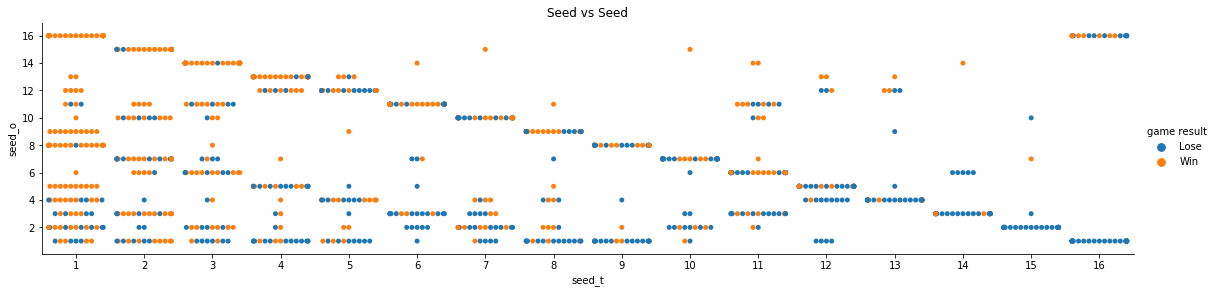

In [19]:
g = sns.catplot(x="seed_t", y="seed_o", hue="game result", 
                height=4, aspect=4,data=tourney_comp_ratings,kind='swarm')
plt.title('Seed vs Seed')
plt.show()

### Upset Plots

##### High Stats

In [20]:
total_games =0
tournament_games = {}
for year in range(2003,2018,1):
    tournament_games[year] = tourney_comp_ratings[tourney_comp_ratings['season_t'] == year].shape[0]
    total_games += tournament_games[year]
    
print('total games= ', total_games)

total games=  978


C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


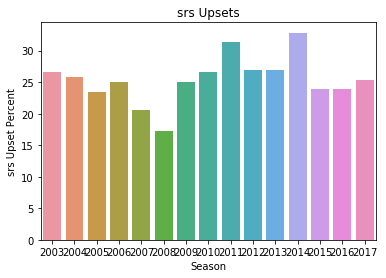

Total upsets=  249
Percentage Tournament Game Upsets 25.460%




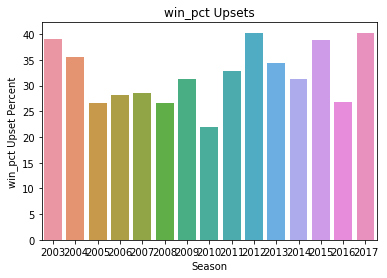

Total upsets=  315
Percentage Tournament Game Upsets 32.209%




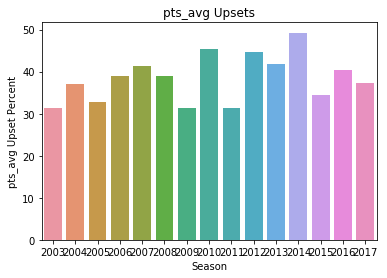

Total upsets=  376
Percentage Tournament Game Upsets 38.446%




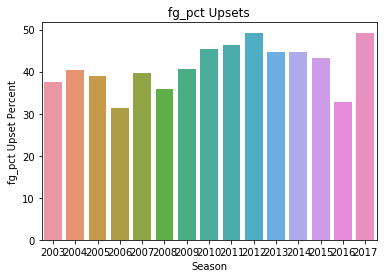

Total upsets=  405
Percentage Tournament Game Upsets 41.411%




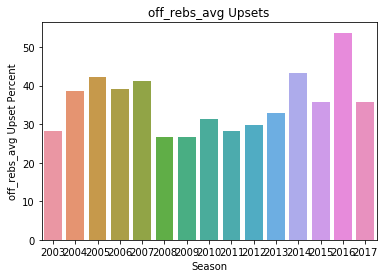

Total upsets=  348
Percentage Tournament Game Upsets 35.583%




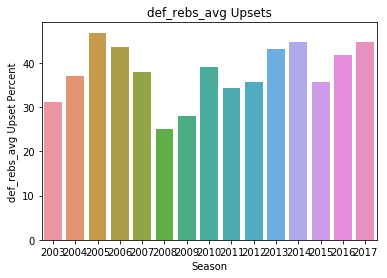

Total upsets=  372
Percentage Tournament Game Upsets 38.037%




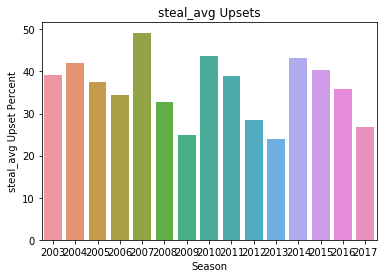

Total upsets=  352
Percentage Tournament Game Upsets 35.992%




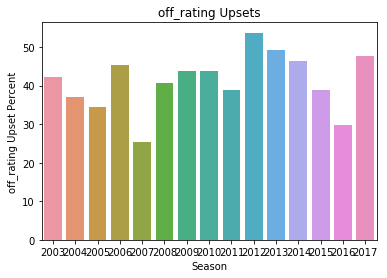

Total upsets=  403
Percentage Tournament Game Upsets 41.207%




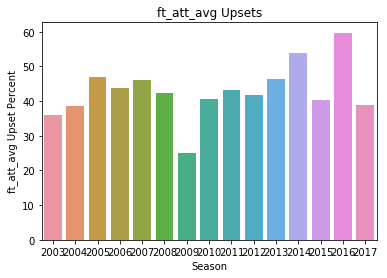

Total upsets=  420
Percentage Tournament Game Upsets 42.945%




In [21]:
ratings_dict={}
high_stats = ['srs','win_pct','pts_avg','fg_pct','off_rebs_avg','def_rebs_avg','steal_avg','off_rating','ft_att_avg']
#high_stats = ['off_rating']
for stat in high_stats:
    stat_t = stat + '_t'
    stat_o = stat + '_o'
    upset_cond_1 = (tourney_comp_ratings['game_result'] == -1) & (tourney_comp_ratings[stat_t] > tourney_comp_ratings[stat_o])
    upset_cond_2 = (tourney_comp_ratings['game_result'] == 1) & (tourney_comp_ratings[stat_t] < tourney_comp_ratings[stat_o])
    upsets = tourney_comp_ratings[upset_cond_1 | upset_cond_2][['season_t', 'team_t','team_o','game_result',stat_t , stat_o ]]
    plot = sns.barplot(x='season_t', y='season_t',data=upsets, orient='v', 
                       estimator=lambda x: utils.compute_percentage(x, tournament_games))
    plot.set(xlabel='Season', ylabel=stat +' Upset Percent')
    plot.set_title(stat + " Upsets")
    plt.show()
    print("Total upsets= ", upsets.shape[0])
    percent_upsets = upsets.shape[0]*100/total_games
    print("Percentage Tournament Game Upsets {:.3f}%".format( percent_upsets))
    print("\n")
    ratings_dict[stat] =  percent_upsets

##### Low Stat Upsets (The team that won had a greater number in these categories)

C:\Users\CHIPK\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


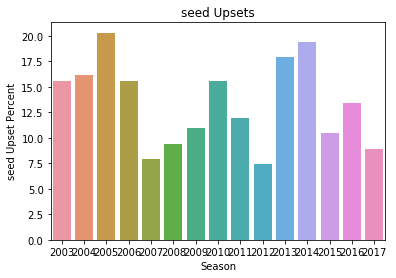

Percentage Tournament Game Upsets 13.395%


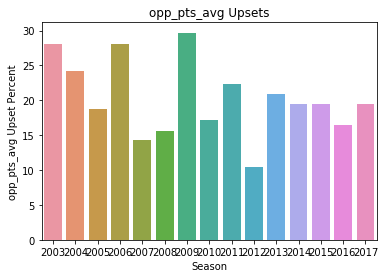

Percentage Tournament Game Upsets 20.245%


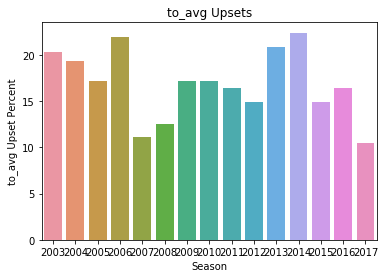

Percentage Tournament Game Upsets 16.871%


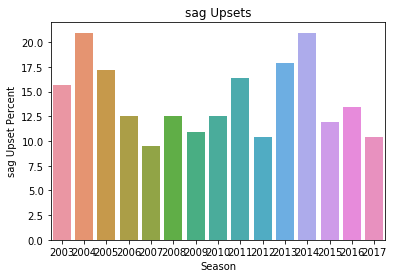

Percentage Tournament Game Upsets 14.213%


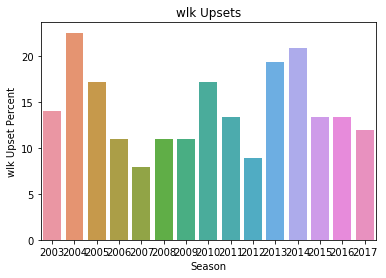

Percentage Tournament Game Upsets 14.213%


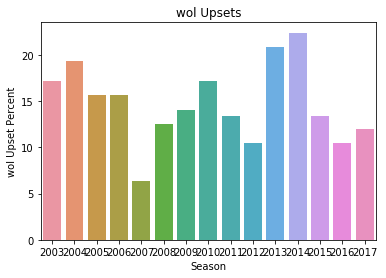

Percentage Tournament Game Upsets 14.724%


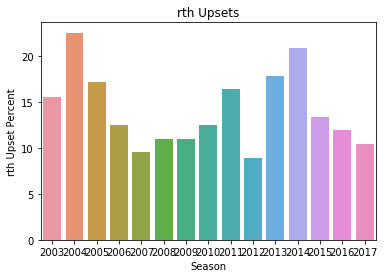

Percentage Tournament Game Upsets 14.110%


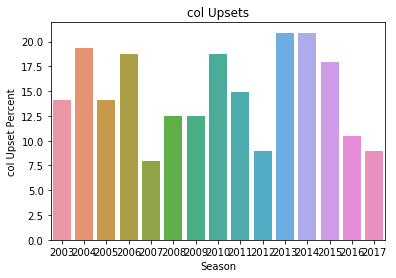

Percentage Tournament Game Upsets 14.724%


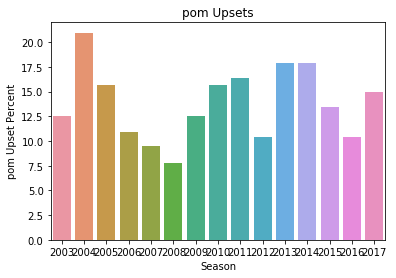

Percentage Tournament Game Upsets 13.804%


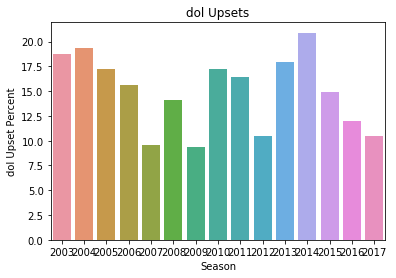

Percentage Tournament Game Upsets 14.928%


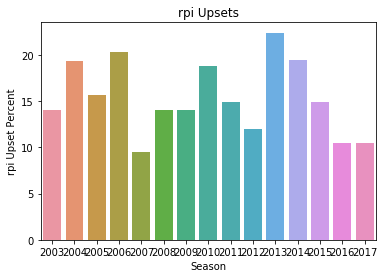

Percentage Tournament Game Upsets 15.337%


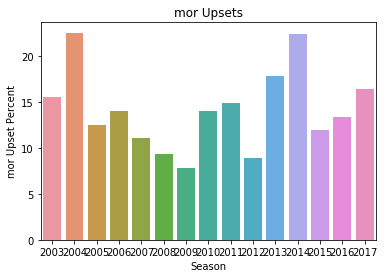

Percentage Tournament Game Upsets 14.213%


In [22]:

low_stats = ['seed','opp_pts_avg','to_avg','sag','wlk','wol',
             'rth','col','pom','dol','rpi','mor' ]
#high_stats = ['off_rating']
for stat in low_stats:
    stat_t = stat + '_t'
    stat_o = stat + '_o'
    upset_cond_1 = (tourney_comp_ratings['game_result'] == 0) & (tourney_comp_ratings[stat_t] <tourney_comp_ratings[stat_o])
    upset_cond_2 = (tourney_comp_ratings['game_result'] == 1) & (tourney_comp_ratings[stat_t] > tourney_comp_ratings[stat_o])
    upsets = tourney_comp_ratings[upset_cond_1 | upset_cond_2][['season_t', 'team_t','team_o','game_result',stat_t , stat_o ]]
    plot = sns.barplot(x='season_t', y='season_t',data=upsets, orient='v', 
                       estimator=lambda x: utils.compute_percentage(x, tournament_games))
    plot.set(xlabel='Season', ylabel=stat +' Upset Percent')
    plot.set_title(stat + " Upsets")
    plt.show()
    percent_upsets = upsets.shape[0]*100/total_games
    print("Percentage Tournament Game Upsets {:.3f}%".format( percent_upsets))
    ratings_dict[stat] =  percent_upsets

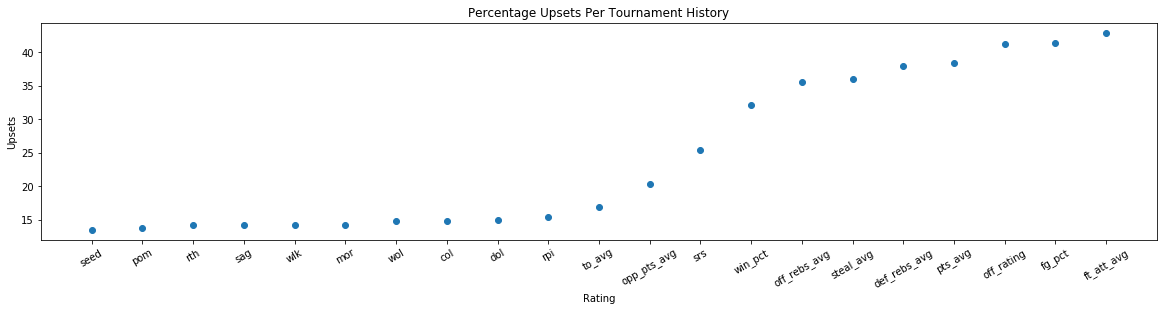

In [23]:
sorted_ratings = sorted(ratings_dict.items(), key=operator.itemgetter(1))
sorted_ratings
g= plt.scatter(*zip(*sorted_ratings))
plt.title('Percentage Upsets Per Tournament History')
plt.xlabel('Rating')
plt.ylabel('Upsets')
plt.xticks(rotation=30)
g.figure.set_size_inches(20,4)
plt.show()

In [24]:

high_stats = ['srs']
#high_stats = ['off_rating']
for stat in high_stats:
    stat_t = stat + '_t'
    stat_o = stat + '_o'
    upset_cond_1 = (tourney_comp_ratings['game_result'] == 0) & (tourney_comp_ratings[stat_t] > tourney_comp_ratings[stat_o])
    upset_cond_2 = (tourney_comp_ratings['game_result'] == 1) & (tourney_comp_ratings[stat_t] < tourney_comp_ratings[stat_o])
    upsets = tourney_comp_ratings[upset_cond_1 | upset_cond_2][['season_t','round','team_t','team_o','seed_t','seed_o',
                                                       'game result','win_pct_t','win_pct_o','to_avg_t','to_avg_o',
                                                       'srs_t','srs_o','off_rebs_avg_t','off_rebs_avg_o']]
    
upsets    

,season_t,round,team_t,team_o,seed_t,seed_o,game result,win_pct_t,win_pct_o,to_avg_t,to_avg_o,srs_t,srs_o,off_rebs_avg_t,off_rebs_avg_o
3,2012,64,Virginia Commonwealth,Wichita State,12,5,Win,0.806,0.818,11.0,12.0,8.79,17.42,12.0,10.0
5,2011,16,Virginia Commonwealth,Florida State,11,10,Win,0.700,0.676,11.0,15.0,8.56,13.48,10.0,12.0
7,2011,32,Virginia Commonwealth,Purdue,11,3,Win,0.700,0.765,11.0,10.0,8.56,19.36,10.0,11.0
9,2011,68,Virginia Commonwealth,USC,11,11,Win,0.700,0.559,11.0,11.0,8.56,11.52,10.0,10.0
11,2013,64,Colorado State,Missouri,8,9,Win,0.743,0.676,11.0,13.0,13.65,15.41,14.0,13.0
17,2003,64,Utah,Oregon,9,8,Win,0.758,0.697,12.0,15.0,11.00,14.05,10.0,11.0
29,2014,64,Mercer,Duke,14,3,Win,0.750,0.743,11.0,9.0,5.33,19.51,11.0,11.0
31,2005,64,Bucknell,Kansas,14,3,Win,0.697,0.767,15.0,14.0,2.12,20.68,9.0,11.0
33,2012,68,South Florida,California,12,12,Win,0.611,0.706,13.0,12.0,9.20,13.79,10.0,10.0
39,2013,64,Oregon,Oklahoma State,12,5,Win,0.757,0.727,15.0,12.0,13.82,15.57,12.0,10.0


In [25]:
tourney_comp_ratings.shape[0]

978

In [26]:
win_pct_less_zero = tourney_comp_ratings[tourney_comp_ratings['delta_win_pct']< 0]
print("Win pct < 0: ",win_pct_less_zero.shape[0])
print("Team wins when Win pct < 0= ",win_pct_less_zero[win_pct_less_zero['game_result']==1].shape[0],' Percentage= ',
     100 *win_pct_less_zero[win_pct_less_zero['game_result']==1].shape[0]/win_pct_less_zero.shape[0])

Win pct < 0:  484
Team wins when Win pct < 0=  157  Percentage=  32.43801652892562


In [27]:
tourney_comp_ratings[tourney_comp_ratings['delta_win_pct']< 0.157].shape[0]

865

In [28]:
tourney_comp_ratings[tourney_comp_ratings['delta_win_pct']<-0.001].shape[0]

484

In [29]:
feature_data = tourney_comp_ratings.drop(
        columns=['round', 'game_date', 'seed_t', 'team_t', 'team_id_t', 'team_id_o',
                 'team_o', 'seed_o', 'team_id_o', 'game_result', 'start_season', 'game result',
                 'conf_name_t', 'conf_name_o']).copy()

feature_data.drop(columns=['pts_avg_t', 'pts_avg_o', 'opp_pts_avg_t', 'opp_pts_avg_o',
                               'margin_victory_avg_t', 'margin_victory_avg_o',
                               'poss_avg_t', 'poss_avg_o',
                               'fg_pct_t', 'fg_pct_o',
                               'off_rebs_avg_t', 'off_rebs_avg_o', 'def_rebs_avg_t', 'def_rebs_avg_o',
                               'ft_pct_t', 'ft_pct_o',
                               'to_avg_t', 'to_avg_o', 'steal_avg_t', 'steal_avg_o',
                               'to_net_avg_t', 'to_net_avg_o',
                               'win_pct_t', 'win_pct_o', 'off_rating_t', 'off_rating_o',
                               'ft_att_avg_t', 'ft_att_avg_o', 'opp_pts_avg_t', 'opp_pts_avg_o',
                               'srs_t', 'srs_o', 'sos_t', 'sos_o',
                               'sag_t', 'sag_o', 'wlk_t', 'wlk_o', 'wol_t', 'wol_o',
                               'rth_t', 'rth_o', 'col_t', 'col_o', 'pom_t', 'pom_o',
                               'dol_t', 'dol_o', 'rpi_t', 'rpi_o', 'mor_t', 'mor_o'], inplace=True)

# for now drop the delta seed features
feature_data.drop(columns=['upset_seed_threshold'], inplace=True)


In [30]:
X = feature_data[feature_data['season_t'] >= tournament_season]
y = tourney_comp_ratings[tourney_comp_ratings['season_t'] >= tournament_season]['game_result']
X = X.drop(columns=['season_t'])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

In [32]:
X_train.shape[0]

782

In [33]:
x_y = pd.concat([X_train, y_train], axis=1, join_axes=[X_train.index])
x_y.head()

,top_conf_t,top_conf_o,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor,game_result
783,0,0,-6.0,-0.056,2.0,-3.0,-0.021,0.0,-0.168,-9.428744,1.0,8,-4.03,2.50,22,20.0,43,39,27.0,20.0,31.0,20.0,14,1
123,0,1,2.0,0.004,2.0,-2.0,-0.021,-1.0,0.064,-0.086737,-2.0,1,-2.87,-3.66,25,22.0,3,20,2.0,15.0,18.0,2.0,15,1
234,0,0,-3.0,0.002,1.0,3.0,-0.002,3.0,-0.053,-4.493147,-1.0,8,-7.07,-4.22,39,37.0,41,44,36.0,37.0,55.0,39.0,20,-1
718,0,0,-2.0,0.023,-2.0,2.0,-0.044,3.0,-0.091,-1.465399,-2.0,4,-3.07,-1.64,18,19.0,25,21,26.0,16.0,19.0,24.0,5,-1
807,0,0,-2.0,0.019,0.0,2.0,-0.009,1.0,-0.008,-1.814245,3.0,3,-1.59,-0.25,13,14.0,21,19,13.0,17.0,16.0,2.0,31,1


In [ ]:
win_pct_less_zero = x_y[x_y['delta_win_pct'] <=  -0.001]
print("Win pct <= -0.001: ",win_pct_less_zero.shape[0])

number_team_wins = win_pct_less_zero[win_pct_less_zero['game_result'] == 1].shape[0]
print("Team wins when delta  Win pct <= -0.001 = ",number_team_wins,' Percentage= ',
     100 *number_team_wins/win_pct_less_zero.shape[0])

number_opp_wins = win_pct_less_zero[win_pct_less_zero['game_result'] == -1].shape[0]
print("Opp wins when delta Win pct <= -0.001 = ",number_opp_wins,' Percentage= ',
     100 *number_opp_wins/win_pct_less_zero.shape[0])

In [ ]:
win_pct_greater_zero = x_y[x_y['delta_win_pct'] >  -0.001]
print("Win pct > -0.001: ",win_pct_greater_zero.shape[0])

number_team_wins = win_pct_greater_zero[win_pct_greater_zero['game_result'] == 1].shape[0]
print("Team wins when delta Win pct > -0.001 = ",number_team_wins,' Percentage= ',
     100 *number_team_wins/win_pct_greater_zero.shape[0])

number_opp_wins = win_pct_greater_zero[win_pct_greater_zero['game_result'] == -1].shape[0]
print("Opp wins when delta Win pct > -0.001 = ",number_opp_wins,' Percentage= ',
     100 *number_opp_wins/win_pct_greater_zero.shape[0])

In [ ]:
x_y[x_y['game_result']==1].shape[0]

In [ ]:
387/782


In [35]:
delta_srs_1_3 = x_y[x_y['delta_srs'] <= 1.3]
print("# records where SRS <= 1.3: ", delta_srs_1_3.shape[0] )

# records where SRS <= 1.3:  438


In [37]:
team_wins = delta_srs_1_3[delta_srs_1_3['game_result'] == 1].shape[0]
team_wins

122

In [42]:
122/782


0.15601023017902813

In [39]:
opp_wins = delta_srs_1_3[delta_srs_1_3['game_result'] == -1].shape[0]
opp_wins

316

In [41]:
316/782


0.4040920716112532

In [48]:
delta_srs_gt_1_3 = x_y[x_y['delta_srs'] > 1.3]
delta_srs_gt_1_3.shape[0]

344

In [51]:
t_wins = delta_srs_gt_1_3[delta_srs_gt_1_3['game_result'] == 1].shape[0]
t_wins/782

0.3388746803069054

In [43]:
delta_srs_2 = x_y[x_y['delta_srs'] <= -8.55]
print("# records where SRS <= =8.55: ",delta_srs_2.shape[0] )

# records where SRS <= =8.55:  143


In [44]:
team_wins = delta_srs_2[delta_srs_2['game_result'] == 1].shape[0]
team_wins

13

In [46]:
13/782

0.016624040920716114